In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
import seaborn as sns
import shap
from IPython.utils import io
import warnings, re, sys, os
from scipy.sparse import issparse
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_validate, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [2]:
warnings.filterwarnings(
    "ignore",
    message="Found unknown categories in columns.*during transform",
    category=UserWarning
)

In [3]:
data = pd.read_csv("/home/winter-storm/f1-data-project/erdos_ds_f1/Patrick/Feature Data Files/final features.csv")

continuous_features_dnf = ['driverExpWeightedSum', 'pitsWeightedSum', 'preRaceALPCWeightedSum', 'TCCAPE', 'clusterMeanWeightedSum',
                           'gapWeightedSum']
categorical_features_dnf = ['topTenDiversity', 'circuitId', 
                            'countryId', 'rain']

dnf_features = continuous_features_dnf + categorical_features_dnf

target = 'totalDNFs'

X_dnf = data[dnf_features]
y = data[target]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_dnf, y, 
                                                    test_size    = 0.2,
                                                    shuffle      = True,
                                                    random_state = 659)

In [5]:
k_fold = KFold(n_splits     = 7,
               shuffle      = True,
               random_state = 659)

In [6]:
handle_nans = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cont', handle_nans, continuous_features_dnf),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), categorical_features_dnf)
], remainder="passthrough")

# Pipeline: preprocessing + random forest
rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=300,
                                        min_samples_split = 20,
                                        min_samples_leaf = 5,
                                        max_features = 0.5,
                                        max_depth = 30, 
                                        random_state=659))
])

In [7]:
rf_pipeline.fit(X_train, y_train)
rf_y_pred = rf_pipeline.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print(f"Random Forest MSE: {rf_mse:.4f}")
print(f"Random Forest R²: {rf_r2:.4f}")

Random Forest MSE: 6.2004
Random Forest R²: 0.6862


In [8]:
def summarize_cv_results(results, model_name="Model"):
    r2_scores = results['test_r2']
    mse_scores = -results['test_neg_mean_squared_error']  # Convert back to positive MSE

    print(f"\n{model_name} Cross-Validation Summary:")
    print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")

def plot_learning_curve(estimator, X_dnf, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_dnf, y, cv=k_fold, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 10),
        shuffle=True, random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training R²')
    plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation R²')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
rf_cv_results = cross_validate(rf_pipeline, X_dnf, y, cv=k_fold,
                               scoring=('r2', 'neg_mean_squared_error'),
                               return_train_score=True)

summarize_cv_results(rf_cv_results, "Random Forest")


Random Forest Cross-Validation Summary:
Average R²: 0.7020 ± 0.0502
Average MSE: 5.7259 ± 0.6589


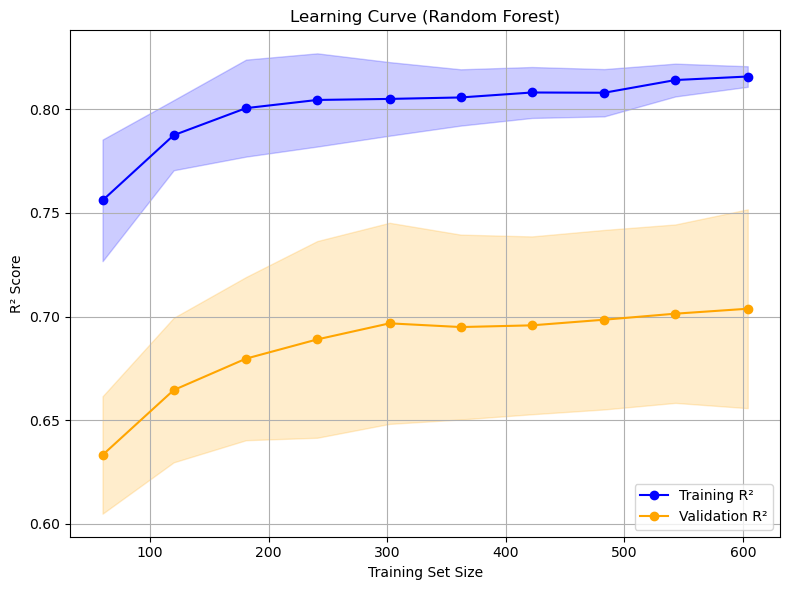

In [10]:
plot_learning_curve(rf_pipeline, X_dnf, y, title="Learning Curve (Random Forest)", cv=k_fold)

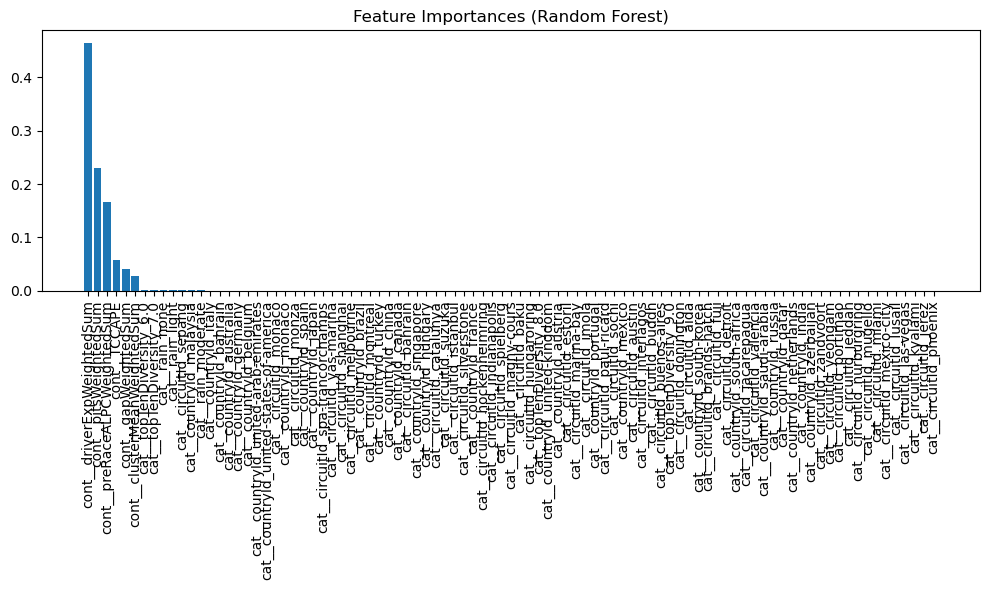

In [12]:
feature_names = rf_pipeline.named_steps["preprocess"].get_feature_names_out()
importances = rf_pipeline.named_steps["regressor"].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [13]:
important_indices = importances > 0.01
selected_features = feature_names[important_indices]
print(selected_features)

['cont__driverExpWeightedSum' 'cont__pitsWeightedSum'
 'cont__preRaceALPCWeightedSum' 'cont__TCCAPE'
 'cont__clusterMeanWeightedSum' 'cont__gapWeightedSum']


In [14]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_leaf': [1, 3, 5],
    'regressor__min_samples_split': [2, 5, 10, 15, 20],
    'regressor__max_features': ['sqrt', 'log2', 0.5, 0.7, None]
}

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=k_fold,                 # your predefined KFold
    scoring='r2',
    n_jobs=-1,                 # use all CPU cores
    verbose=0
)

with io.capture_output() as captured:
    grid_search.fit(X_train, y_train)

print("Done fitting.")

/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3

Done fitting.


In [15]:
print("Best parameters found:", grid_search.best_params_)
print("Best CV R² score: {:.4f}".format(grid_search.best_score_))
best_rf_model = grid_search.best_estimator_

Best parameters found: {'regressor__max_depth': 10, 'regressor__max_features': 0.5, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 20, 'regressor__n_estimators': 300}
Best CV R² score: 0.6979


In [16]:
best_rf_pred = best_rf_model.predict(X_test)
best_rf_mse = mean_squared_error(y_test, best_rf_pred)
best_rf_r2 = r2_score(y_test, best_rf_pred)

print(f"Test MSE (Best RF): {best_rf_mse:.4f}")
print(f"Test R² (Best RF): {best_rf_r2:.4f}")

Test MSE (Best RF): 6.2149
Test R² (Best RF): 0.6855


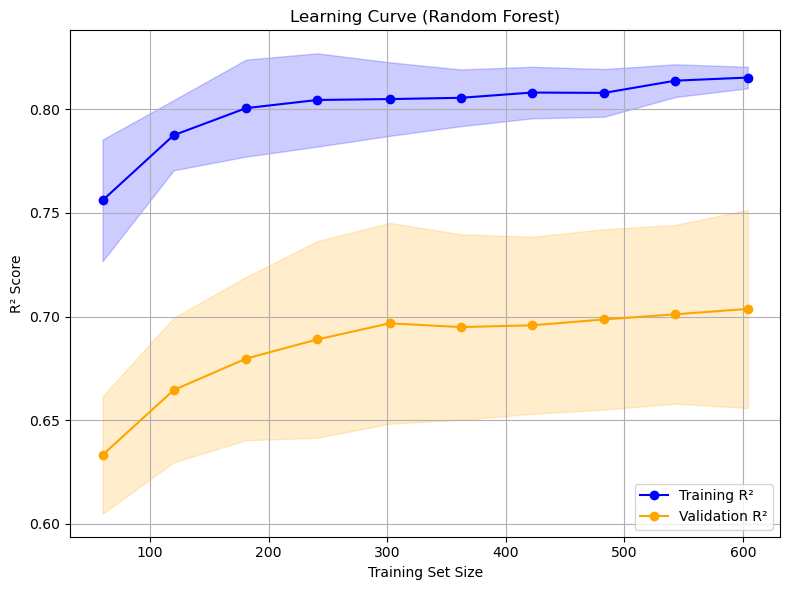

In [17]:
plot_learning_curve(best_rf_model, X_dnf, y, title="Learning Curve (Random Forest)", cv=k_fold)

In [18]:
# Extract model and preprocessing
best_rf = grid_search.best_estimator_.named_steps["regressor"]
preprocessor = grid_search.best_estimator_.named_steps["preprocess"]

# Transform test set (dense array needed)
X_transformed = preprocessor.transform(X_test)
X_dense = X_transformed.astype(np.float32)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

explainer = shap.Explainer(best_rf)
shap_values = explainer(X_dense)

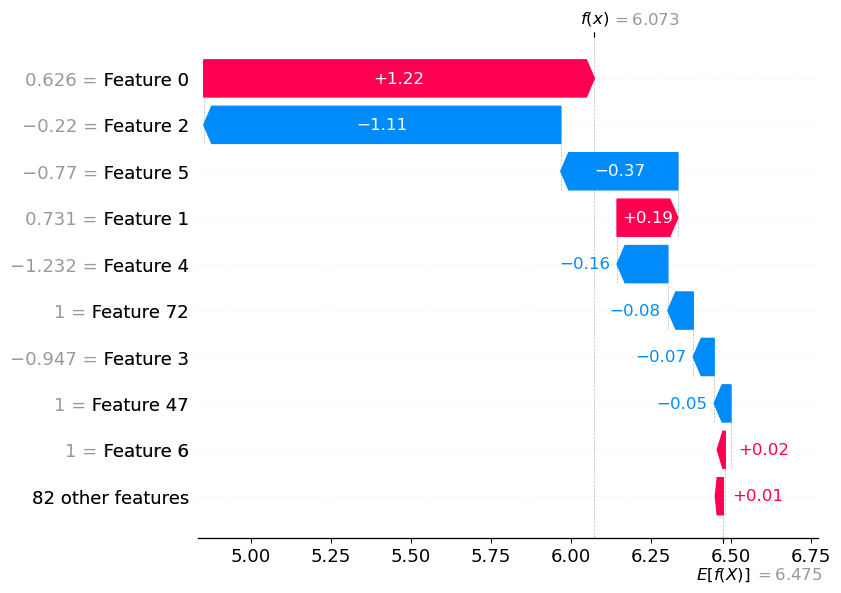

In [19]:
shap.plots.waterfall(shap_values[100])  # First sample


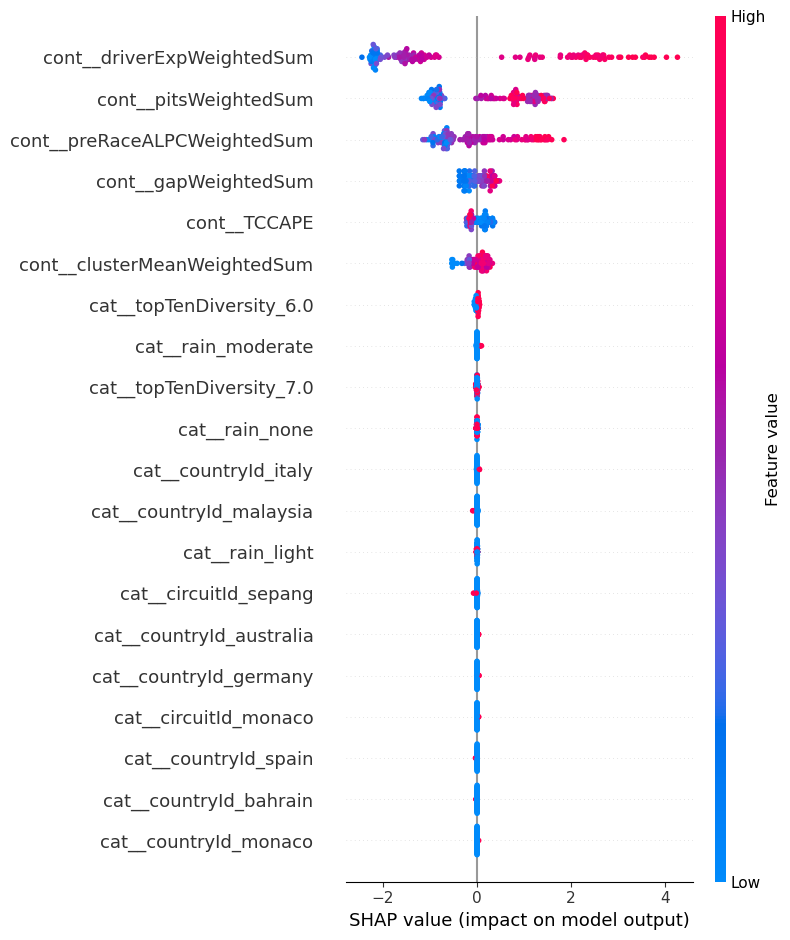

In [20]:
shap.summary_plot(shap_values.values, X_dense, feature_names=feature_names)


In [20]:
# Convert to DataFrame if it's not already
X_vif_df = pd.DataFrame(X_dense, columns=feature_names)

# Optionally drop constant columns (VIF undefined for them)
X_vif_df = X_vif_df.loc[:, X_vif_df.std() > 0]

# Compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_df.values, i) for i in range(X_vif_df.shape[1])]

# Sort by VIF descending
vif_data = vif_data.sort_values(by="VIF", ascending=False)
vif_data.to_csv("VIF Data.csv", index=False)
vif_data

,feature,VIF
19,cat__circuitId_hungaroring,3.216857e+14
54,cat__countryId_hungary,3.216857e+14
60,cat__countryId_monaco,2.814750e+14
30,cat__circuitId_monaco,2.814750e+14
42,cat__circuitId_yas-marina,1.916425e+14
...,...,...
1,cont__qualifyingALPC,3.085834e+00
10,cat__topTenDiversity_8,2.618286e+00
3,cont__First_ten_gap,2.535938e+00
2,cont__FRALPC,2.464434e+00
